In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import spaceoracle
from spaceoracle import SpaceOracle

In [5]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [6]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

In [8]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [9]:
from spaceoracle.tools.utils import search

In [91]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Cd74',
)

In [92]:
%%time

estimator.fit(num_epochs=30, threshold_lambda=1e-4, learning_rate=1e-3)

Fitting Cd74 with 156 modulators
	36 Transcription Factors
	27 Ligand-Receptor Pairs
	93 TranscriptionFactor-Ligand Pairs
0: 0.9866 | 0.9896
1: 0.9579 | 0.9709
2: 0.9655 | 0.9756
3: 0.2954 | 0.9662
4: 0.7339 | 0.9893
5: 0.5181 | 0.9803
6: 0.5186 | 0.9870
CPU times: user 52.6 s, sys: 15.9 s, total: 1min 8s
Wall time: 1min 22s


In [93]:
estimator.betadata.to_parquet(f'./models/{estimator.target_gene}_betadata.parquet')

In [94]:
# df = estimator.betadata
# betas = torch.from_numpy(
#     df[['beta0']+['beta_'+i for i in estimator.modulators]].values).float()

# inputs_x = torch.from_numpy(
#     estimator.train_df.drop(
#         columns=estimator.target_gene).values).float()

In [95]:
# plt.rcParams['figure.figsize'] = (25, 3)
# plt.rcParams['figure.dpi'] = 120

# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' not in i and '$' not in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

# plt.rcParams['figure.figsize'] = (25, 5)
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

In [96]:
# y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

# r2_score(
#     estimator.train_df[estimator.target_gene], 
#     y_pred.cpu().numpy()
# )

In [97]:
cmaps = dict(zip(range(7), ['rainbow', 'hot', 'cool_r', 'spring', 'viridis', 'PuRd', 'Reds']))


In [98]:
from spaceoracle.oracles import SpaceOracle

so = SpaceOracle(adata=adata_train)
beta_dict = {estimator.target_gene: so._get_betas(estimator.target_gene)}

gex_df = estimator.adata.to_df()
beta_dict = so._get_wbetas_dict(beta_dict, gex_df, n_jobs=1)
wbetas = beta_dict[estimator.target_gene].wbetas


# reformat betas so it's the same as when plot method was written
xy = pd.DataFrame(
    adata_train.obsm['spatial'], index=adata_train.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(adata_train.obs) \
        .join(xy)

df

  0%|          | 0/1 [00:00<?, ?it/s]

beta_Angptl2  beta_Angptl4  beta_Atf3  beta_Bcl11a  \
AAAAAACGGTAGAT           0.0      0.000000   0.000000     0.144527   
AAAAAATCCGGCGA           0.0      0.000000  -0.012057     0.050530   
AAAAACCGTCAGAC           0.0      0.000000   0.000000     0.144240   
AAAAACGCTCCGAC           0.0      0.000000   0.000000     0.144606   
AAAAAGCACGTGTT           0.0      0.000000   0.000000     0.144155   
...                      ...           ...        ...          ...   
TTTTTTCGCGGCTA           0.0      0.000000  -0.010711     0.058744   
TTTTTTGGGCTGGT           0.0      0.000000   0.000000     0.143529   
TTTTTTGTACCCAC           0.0      0.000000   0.000000     0.143701   
TTTTTTGTACGATT           0.0      0.000000   0.000000     0.144260   
TTTTTTTTGCTTTA           0.0     -0.017865   0.000000     0.144506   

                beta_Bcl11b  beta_C3  beta_C4b  beta_Cebpb  beta_Clcf1  \
AAAAAACGGTAGAT    -0.128984      0.0       0.0    0.023531    0.031610   
AAAAAATCCGGCGA    -0.010466      0.0       0.0    0.013667    0.000000   
AAAAACCGTCAGAC    -0.128916      0.0       0.0    0.023443   -0.000356   
AAAAACGCTCCGAC    -0.129257      0.0       0.0    0.023698    0.000000   
AAAAAGCACGTGTT    -0.128761      0.0       0.0    0.023369    0.000000   
...                     ...      ...       ...         ...         ...   
TTTTTTCGCGGCTA    -0.007014      0.0       0.0    0.011402    0.000000   
TTTTTTGGGCTGGT    -0.047424      0.0       0.0    0.018152    0.000000   
TTTTTTGTACCCAC    -0.046937      0.0       0.0    0.018087    0.000000   
TTTTTTGTACGATT    -0.128851      0.0       0.0    0.023462   -0.001436   
TTTTTTTTGCTTTA    -0.128962      0.0       0.0    0.023531    0.000000   

                beta_Cr2  ...   beta_Tcf7l2  beta_Tnfrsf13c  beta_Tnfsf13b  \
AAAAAACGGTAGAT  0.000018  ...  0.000000e+00    2.321417e-09       0.000000   
AAAAAATCCGGCGA  0.000001  ...  0.000000e+00    3.083658e-25       0.000000   
AAAAACCGTCAGAC  0.000005  ...  0.000000e+00    4.874802e-29       0.042436   
AAAAACGCTCCGAC  0.000009  ...  0.000000e+00    1.646298e-38       0.000000   
AAAAAGCACGTGTT  0.000020  ...  0.000000e+00    9.736399e-07       0.040707   
...                  ...  ...           ...             ...            ...   
TTTTTTCGCGGCTA  0.000002  ...  0.000000e+00    3.165267e-09       0.000000   
TTTTTTGGGCTGGT  0.000004  ...  2.150847e-08    5.644258e-17       0.000000   
TTTTTTGTACCCAC  0.000006  ...  6.078967e-13    2.471949e-13       0.000000   
TTTTTTGTACGATT  0.000023  ...  0.000000e+00    1.141441e-13       0.000000   
TTTTTTTTGCTTTA  0.000025  ...  0.000000e+00    3.325830e-11       0.000000   

                beta_Zbtb6  beta_Zkscan1  cluster  rctd_cluster  \
AAAAAACGGTAGAT         0.0      0.000000        5             0   
AAAAAATCCGGCGA         0.0      0.000000       12             4   
AAAAACCGTCAGAC         0.0      0.000000        1             0   
AAAAACGCTCCGAC         0.0      0.000000        1             0   
AAAAAGCACGTGTT         0.0      0.000000        0             0   
...                    ...           ...      ...           ...   
TTTTTTCGCGGCTA         0.0      0.000000        5             4   
TTTTTTGGGCTGGT         0.0     -0.003702        0             2   
TTTTTTGTACCCAC         0.0     -0.003528        3             2   
TTTTTTGTACGATT         0.0      0.000000        1             0   
TTTTTTTTGCTTTA         0.0      0.000000        5             0   

                rctd_celltypes       x       y  
AAAAAACGGTAGAT          B-cell -4252.0  2626.2  
AAAAAATCCGGCGA             Tfh -2952.4  1975.3  
AAAAACCGTCAGAC          B-cell -2480.0  1516.6  
AAAAACGCTCCGAC          B-cell -2764.1  1255.7  
AAAAAGCACGTGTT          B-cell -3925.9  1618.5  
...                        ...     ...     ...  
TTTTTTCGCGGCTA             Tfh -3754.4  1504.7  
TTTTTTGGGCTGGT             Th2 -3547.4  2483.1  
TTTTTTGTACCCAC             Th2 -1666.5  2309.1  
TTTTTTGTACGATT          B-cell -2052.1  2937.7  
TTTTT

In [99]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    # Get cluster-specific min/max for individual colorbar scales
    norms = {}
    for i in clusters:
        cluster_data = df[df.rctd_cluster==i][plot_for]
        vmin = cluster_data.min()
        vmax = cluster_data.max()
        norms[i] = plt.Normalize(vmin=vmin, vmax=vmax)

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            alpha=alpha,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norms[i])
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

In [ ]:
plot('beta_Pax5', dpi=100, size=20, with_expr=False)

<Axes: title={'center': 'beta_Pax5 > Cd74'}, xlabel='x', ylabel='y'>

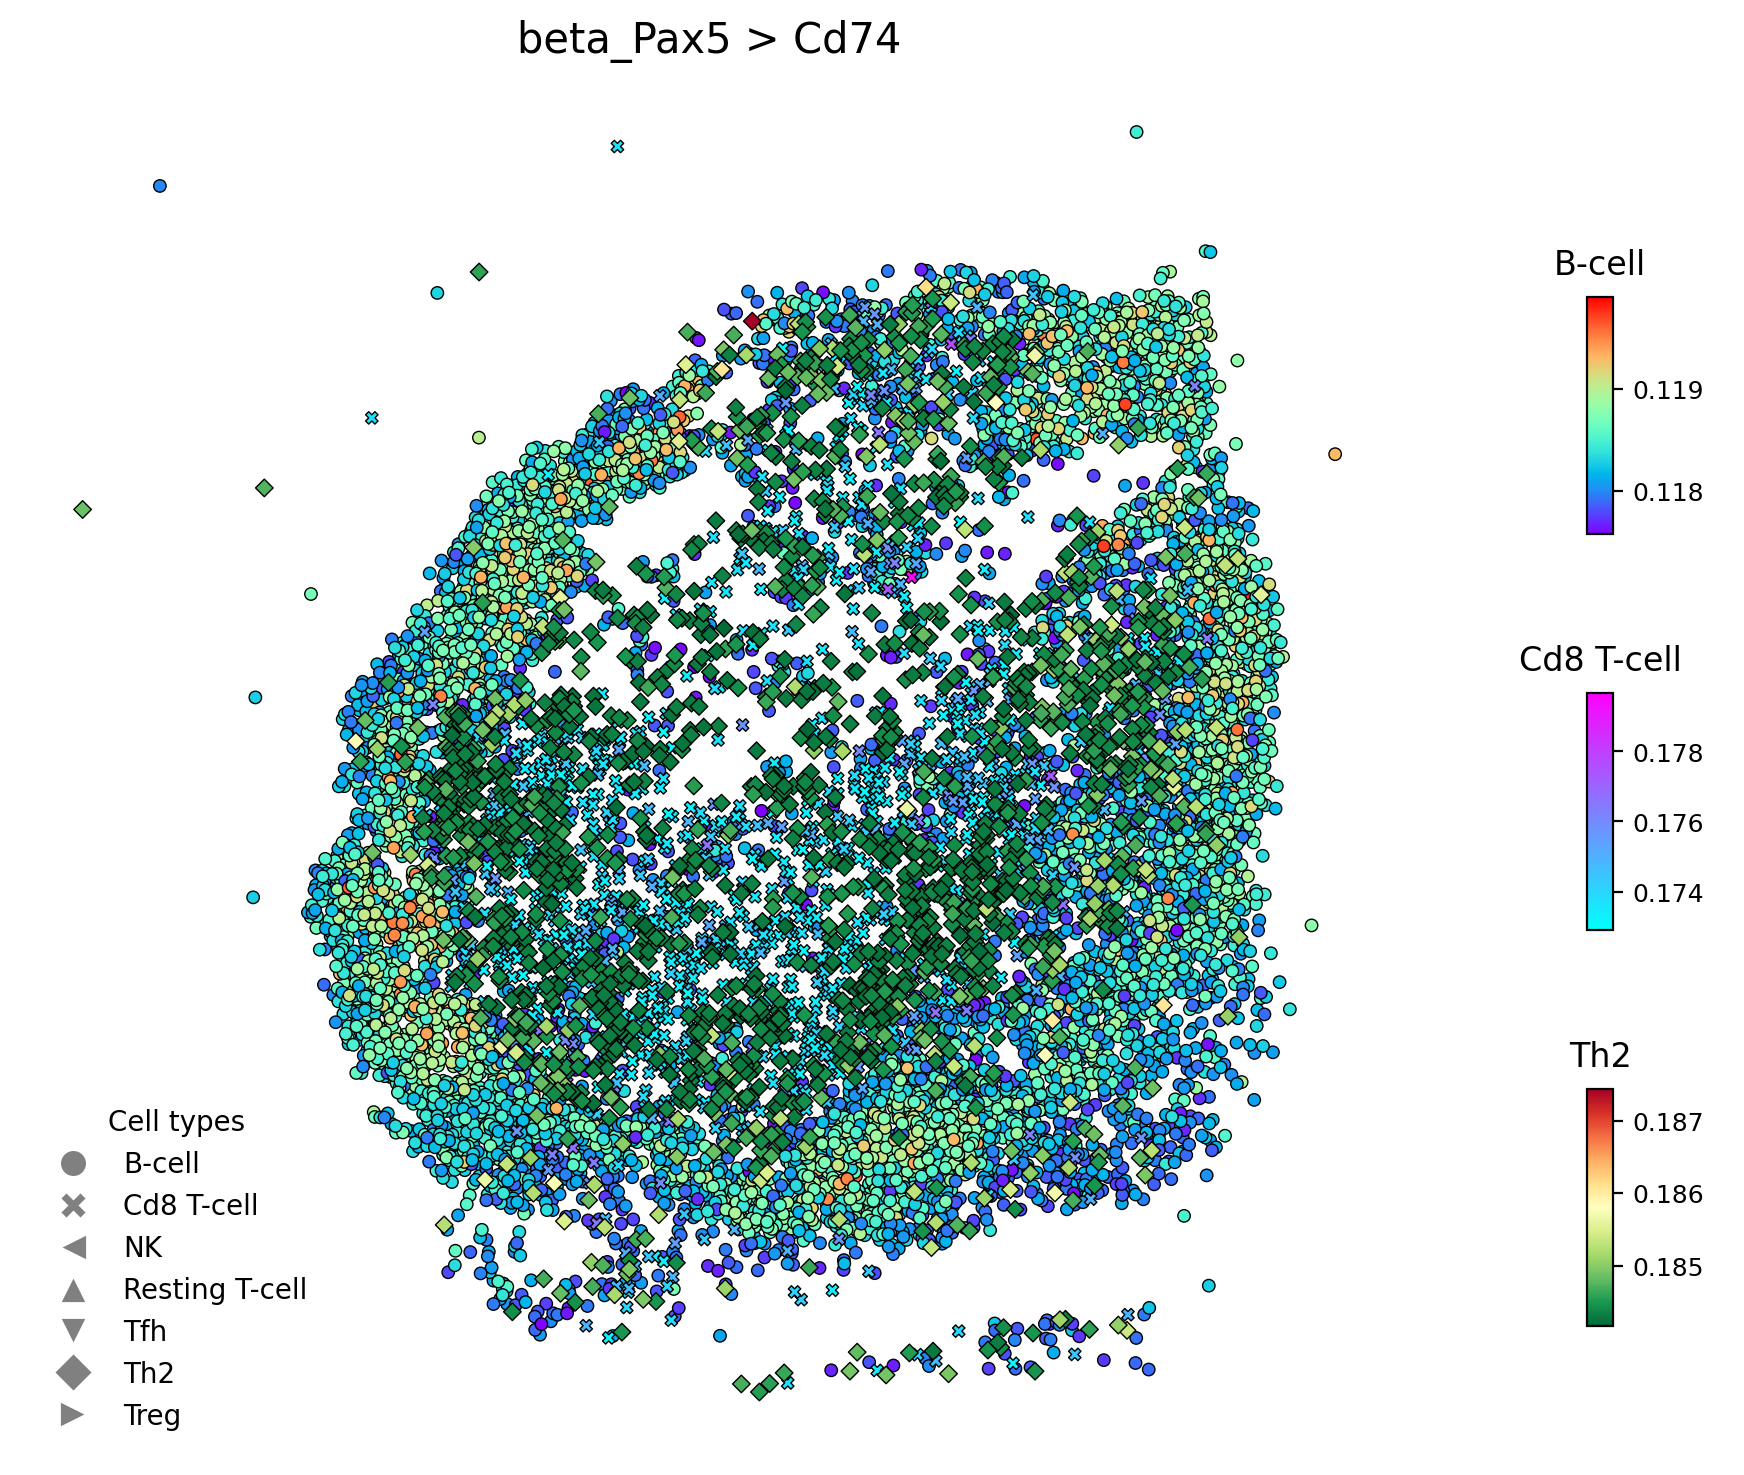

In [105]:
plot('beta_Pax5', dpi=100, size=20, with_expr=True)

<Axes: title={'center': 'beta_Il2 > Cd74'}, xlabel='x', ylabel='y'>

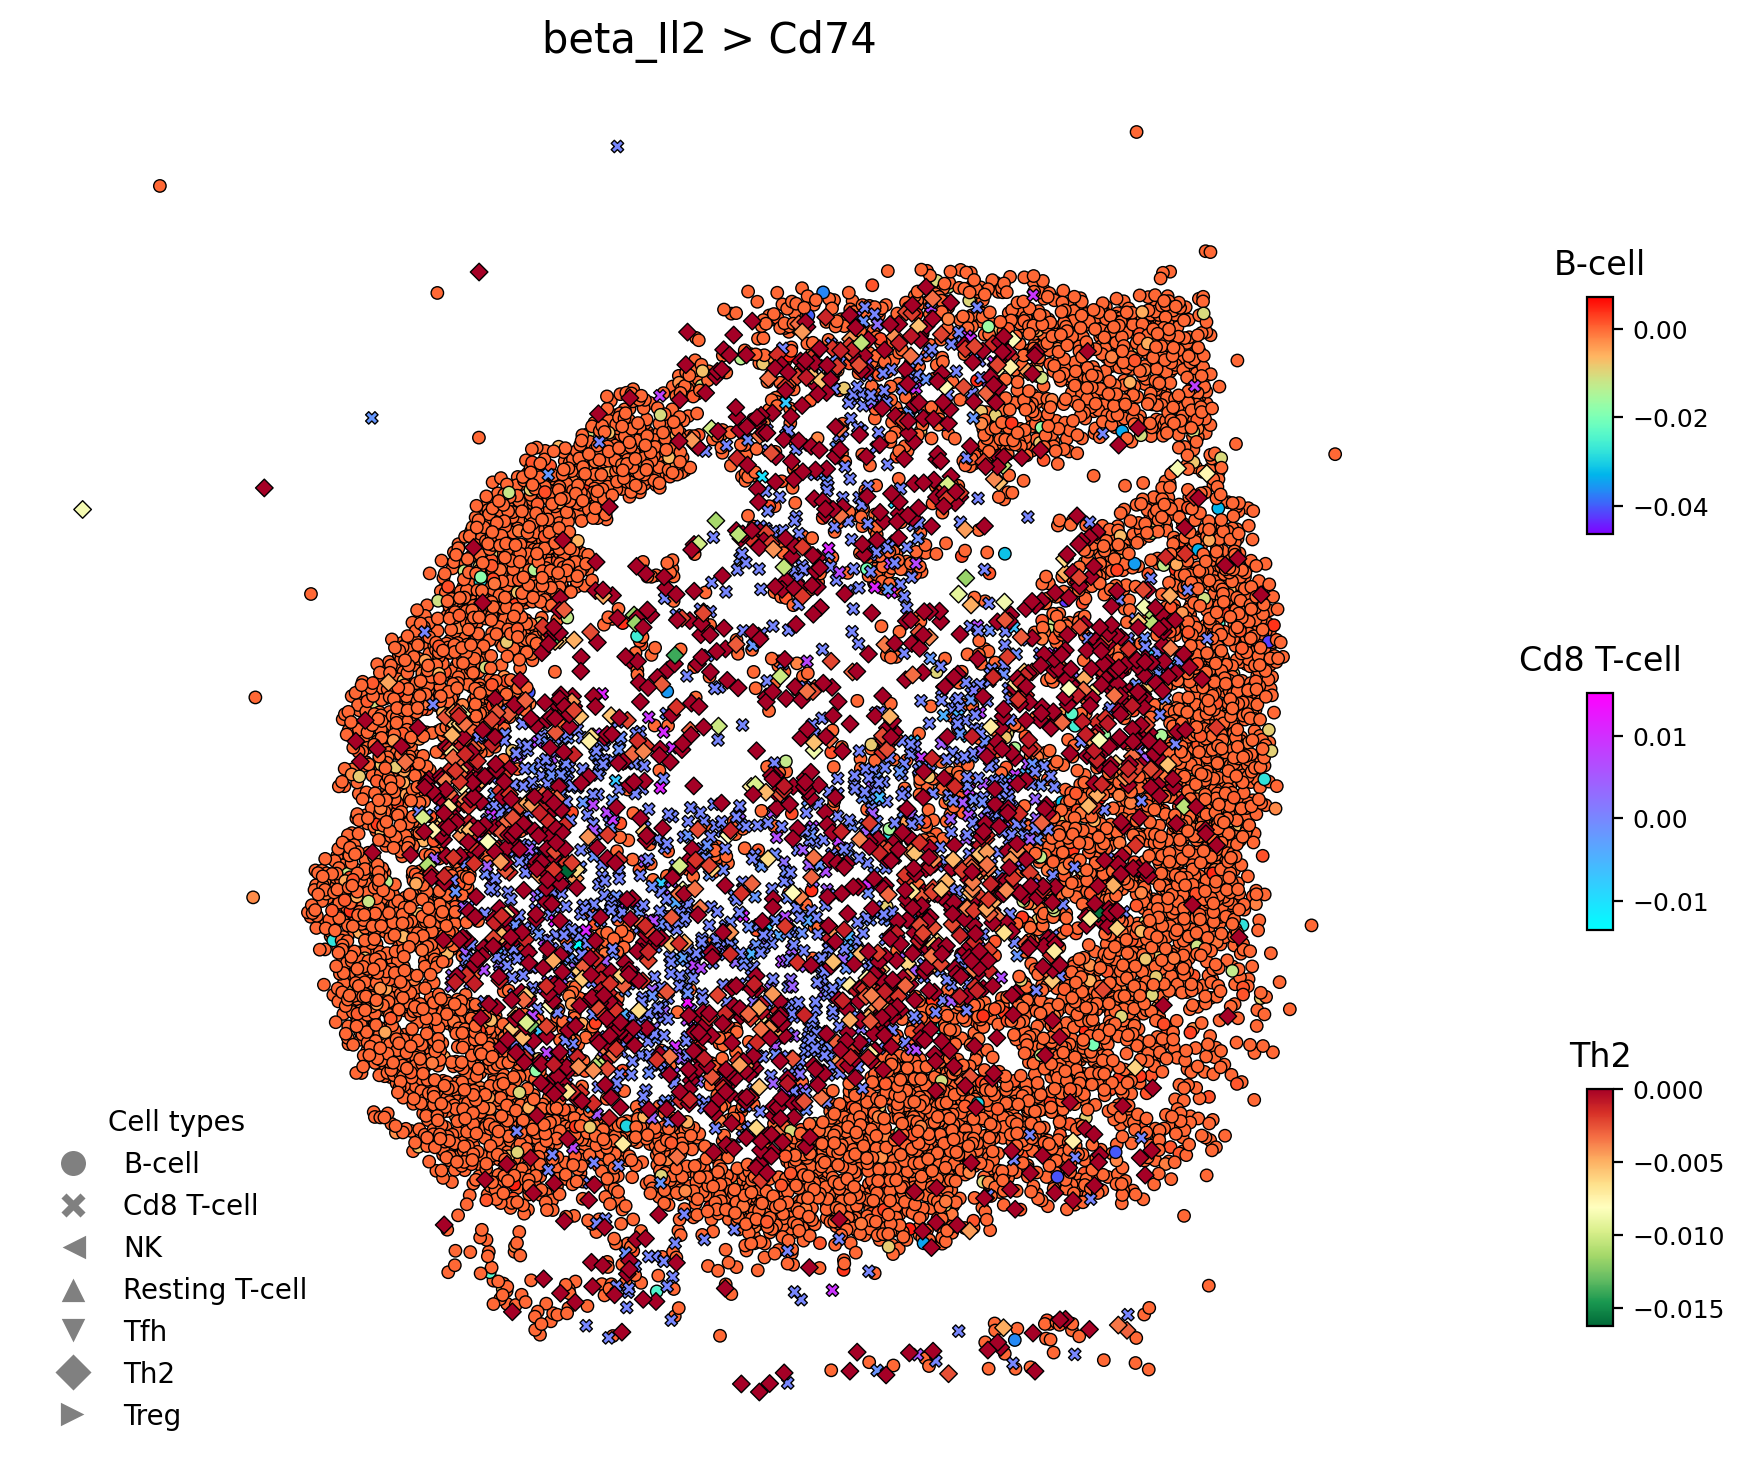

In [104]:
plot('beta_Il2', dpi=100, size=20)

ValueError: Could not interpret value `beta_Il2#Egr2` for `hue`. An entry with this name does not appear in `data`.

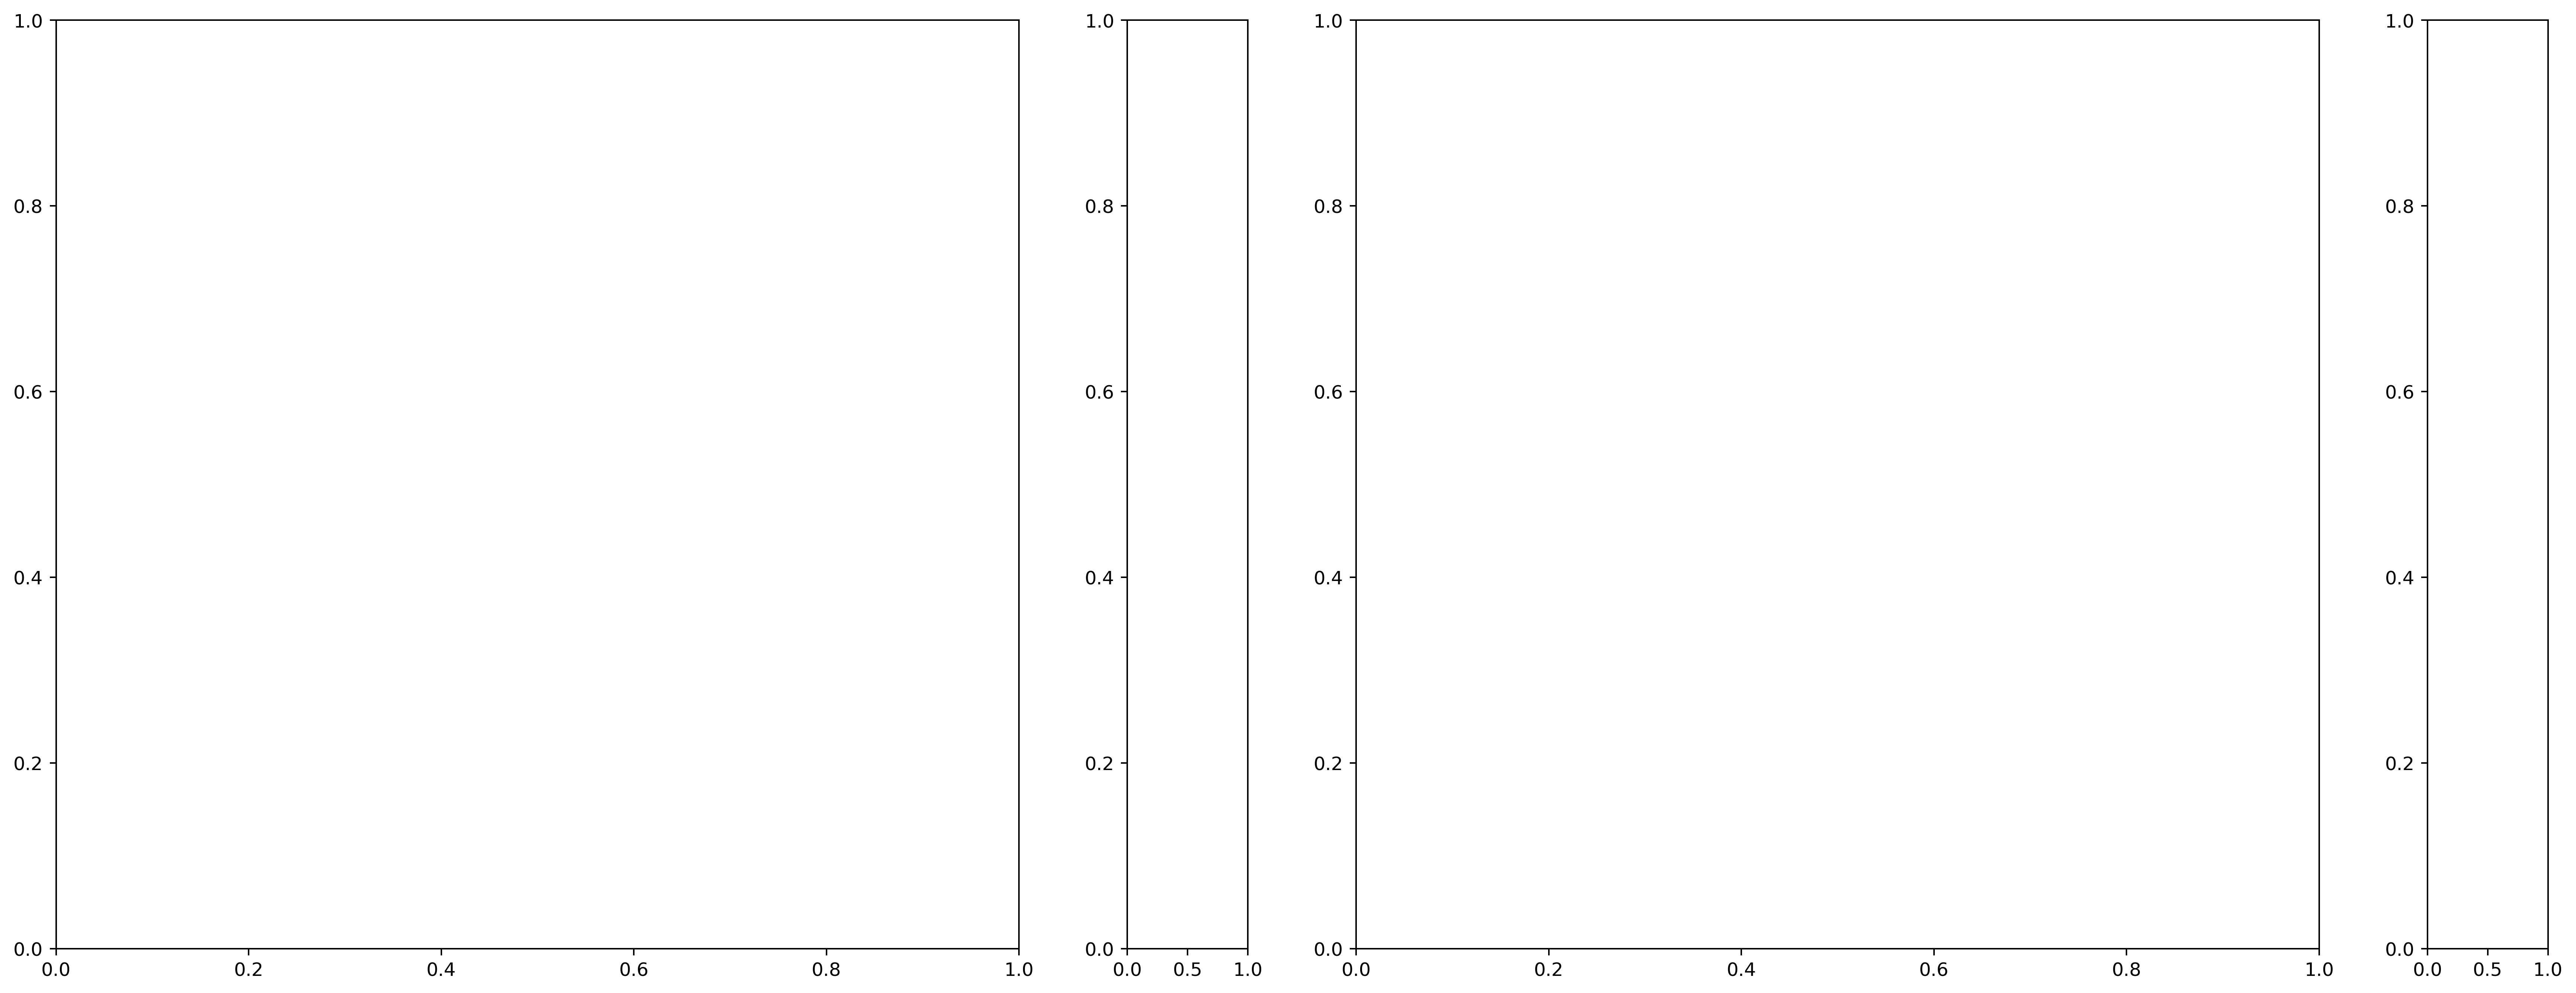

In [70]:
fig, axs = plt.subplots(1, 4, dpi=180, figsize=(12*2, 9*1), gridspec_kw={'width_ratios': [4, 0.5]*2})
axs = axs.flatten()
axs = [(axs[i], axs[i+1]) for i in range(0, len(axs), 2)]
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[0])
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[1], with_expr=True)
# plot('Egr2', dpi=100, size=20, fig=fig, axes=axs[2])
# plot('Il2', dpi=100, size=20, fig=fig, axes=axs[3])
# plot('beta_Egr2', dpi=100, size=20, fig=fig, axes=axs[4])
# plot('Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[5])
plt.show()
